In [1]:
import sys
if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

# ______________________________________________________________________________
import numpy as np

from emtf_algos import *
from emtf_logger import *

In [2]:
import sys
import os
#os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

import numba
from numba import njit, vectorize
import dask
import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
logger.info('Using numba      : {0}'.format(numba.__version__))
logger.info('Using dask       : {0}'.format(dask.__version__))

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.18.5
[INFO    ] Using tensorflow : 2.2.0
[INFO    ] Using keras      : 2.3.0-tf
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
[INFO    ] Using matplotlib : 3.2.2
[INFO    ] Using numba      : 0.50.1
[INFO    ] Using dask       : 2.20.0


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(-1,0,+1)
timezone = 1

#maxevents = 200000
maxevents = -1

# Input files
signal_fname = 'signal_add.20200721.npz'
signal_displ_fname = 'signal_displ_add.20200721.npz'
bkgnd_fname = 'bkgnd_add.20200716.npz'

# Input data columns
part_metadata = ['part_invpt', 'part_eta', 'part_phi',
                 'part_vx', 'part_vy', 'part_vz',
                 'part_d0', 'part_sector', 'part_zone']
part_metadata = dict(zip(part_metadata, range(len(part_metadata))))
#print(part_metadata)

hits_metadata = ['emtf_layer', 'ri_layer', 'zones', 'timezones',
                 'emtf_chamber', 'emtf_segment', 'detlayer', 'bx',
                 'emtf_phi', 'emtf_bend', 'emtf_theta', 'emtf_theta_alt',
                 'emtf_qual', 'emtf_time', 'fr', 'rsvd']
hits_metadata = dict(zip(hits_metadata, range(len(hits_metadata))))
#print(hits_metadata)

# Image format
num_channels = 1
num_cols = 300  # 80 degrees
num_rows = 8
image_format = (num_rows, num_cols, num_channels)

# Image sliding window
image_stride = (min_emtf_strip, max_emtf_strip, coarse_emtf_strip)
assert ((max_emtf_strip - min_emtf_strip) // coarse_emtf_strip) == num_cols

# Box image format
num_box_rows = num_rows
num_box_cols = 111  # 30 degrees
num_box_channels = num_channels
box_image_format = (num_box_rows, num_box_cols, num_box_channels)
box_col_offset = (num_box_cols-1)//2  # (111-1)/2 = 55

# Parameter
num_params = 5

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. image_format     : {0}'.format(image_format))
logger.info('.. image_stride     : {0}'.format(image_stride))
logger.info('.. box_image_format : {0}'.format(box_image_format))
logger.info('.. num_params       : {0}'.format(num_params))

[INFO    ] Processing zone 0 timezone 1
[INFO    ] .. maxevents        : -1
[INFO    ] .. image_format     : (8, 300, 1)
[INFO    ] .. image_stride     : (240, 5040, 16)
[INFO    ] .. box_image_format : (8, 111, 1)
[INFO    ] .. num_params       : 5


In [4]:
# More settings

ind_part_invpt = part_metadata['part_invpt']
ind_part_d0 = part_metadata['part_d0']

ind_ri_layer = hits_metadata['ri_layer']
ind_zones = hits_metadata['zones']
ind_timezones = hits_metadata['timezones']
ind_emtf_phi = hits_metadata['emtf_phi']

anchor_row = find_emtf_zo_layer(3, zone)    # ME2/1
if anchor_row == -99:
  anchor_row = find_emtf_zo_layer(4, zone)  # ME2/2

# Zone-dependent settings
if zone == 0:
  invpt_bins = np.array([-0.49486, -0.30914, -0.18457, -0.06144, 0.06144, 0.18457, 0.30914, 0.49486])
  dzero_bins = np.array([-149.05425911, -81.99509811, -27.70436335, -3.31677109, 3.31677109, 27.70436335, 81.99509811, 149.05425911])
  activation = 0.06
elif zone == 1:
  invpt_bins = np.array([-0.4943, -0.32499, -0.20098, -0.06069, 0.06069, 0.20098, 0.32499, 0.4943])
  dzero_bins = np.array([-148.39244453, -75.48090935, -24.77919722, -2.7400052, 2.7400052, 24.77919722, 75.48090935, 148.39244453])
  activation = 0.06
elif zone == 2:
  invpt_bins = np.array([-0.46452, -0.25713, -0.15333, -0.06148, 0.06148, 0.15333, 0.25713, 0.46452])
  dzero_bins = np.array([-148.3895298, -73.95162964, -24.58334907, -3.2076813, 3.2076813, 24.58334907, 73.95162964, 148.3895298])
  activation = 0.05
else:
  raise RuntimeError('Could not recognize zone: {0}'.format(zone))

num_invpt_bins = len(invpt_bins)-1
num_d0_bins = len(dzero_bins)-1

In [5]:
# Binning functions

def my_digitize(x, bins):
  # first and last bins include underflow and overflow
  ind = np.searchsorted(bins, x)
  ind = np.clip(ind-1, 0, len(bins)-2)  # starts from 0
  return ind

def digitize_invpt_and_d0(invpt, d0):
  # returns (d0_bin, invpt_bin)
  ind0 = my_digitize(invpt, invpt_bins)
  ind1 = my_digitize(d0, dzero_bins)
  return (ind0, ind1)

In [6]:
# Plotting functions

# matplotlib hist2d takes the (x, y) arrays as input, do the binning and plot.
# this hist2d takes a single, already-binned-in-2d, array as input, and plot.
#
# based on root2matplotlib from rootpy:
#     http://www.rootpy.org/_modules/rootpy/plotting/root2matplotlib.html#hist2d
#
def hist2d_on_binned_array(hist, xedges, yedges, ax=None, cmap=None, vmin=None, vmax=None, colorbar=False):
  if ax is None:
    ax = plt.gca()
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = hist.T.ravel()
  h, xedges, yedges, im = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=vmin, vmax=vmax)
  if colorbar:
    cb = ax.figure.colorbar(im, ax=ax)
  return h, xedges, yedges, im

# same thing for 1d
def hist_on_binned_array(hist, edges, ax=None):
  if ax is None:
    ax = plt.gca()
  x = (edges[1:] + edges[:-1])/2
  h, edges, patches = ax.hist(x, weights=hist, bins=edges)
  return h, edges, patches

In [7]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

### Load data

In [8]:
def load_signal(fname):
  logger.info('Loading from {0}'.format(fname))
  with np.load(fname) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    logger.info('out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(fname):
  logger.info('Loading from {0}'.format(fname))
  with np.load(fname) as loaded:
    out_bkg_aux = loaded['out_aux']
    out_bkg_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    logger.info('out_bkg_aux: {0} out_bkg_hits: {1}'.format(out_bkg_aux.shape, out_bkg_hits.shape))
  return (out_bkg_aux, out_bkg_hits)

In [9]:
out_part, out_hits, out_simhits = load_signal(signal_fname)

#out_bkg_aux, out_bkg_hits = load_bkgnd(bkgnd_fname)

[INFO    ] Loading from signal_add.20200721.npz
[INFO    ] out_part: (2000000, 9) out_hits: (2000000, None, 16) out_simhits: (2000000, None, 16)


### Zone selection

In [10]:
# Make zone_mask

part_zone = out_part[:, part_metadata['part_zone']].astype(np.int32)

zone_mask = (part_zone == zone)

atleast_1hit_mask = ~(out_simhits.row_lengths == 0)

zone_mask = zone_mask & atleast_1hit_mask

In [11]:
zone_part = out_part[zone_mask]
zone_hits = ragged_row_boolean_mask(out_hits, zone_mask)
zone_simhits = ragged_row_boolean_mask(out_simhits, zone_mask)

logger.info('zone_part: {0} zone_hits: {1} zone_simhits: {2}'.format(zone_part.shape, zone_hits.shape, zone_simhits.shape))

[INFO    ] zone_part: (786769, 9) zone_hits: (786769, None, 16) zone_simhits: (786769, None, 16)


In [12]:
# Debug
with np.printoptions(linewidth=100, threshold=1000):
  for ievt in range(5):
    print('Event {0}'.format(ievt))
    print(zone_part[ievt])
    print(zone_hits[ievt])
    print(zone_simhits[ievt])

Event 0
[-2.5611117e-01  2.1183386e+00 -6.1635029e-01  6.7432784e-04  9.9125458e-04 -4.6484246e+00
 -1.1986600e-03  5.0000000e+00  0.0000000e+00]
[[   0    0    4    3    2    0    0    0 2548    5   18   17   -6    0    0  -99]
 [   0    0    4    3    2    1    0    0 2548    5   17   18   -6    0    0  -99]
 [   2    3    4    3   19    0    0    0 2684    2   16   16    6    0    1  -99]
 [   3    5    4    3   28    0    0    0 2819   15   17   16   -5    0    0  -99]
 [   3    5    4    3   28    1    0    0 2728    0   16   17   -5    0    0  -99]
 [   4    7    4    3   37    0    0    0 2736    0   16   16   -5    0    0  -99]
 [   9    9    4    2   55    0    0    0 2505    0   18   18    0    0    1  -99]
 [  10   12    4    2   73    0    0    0 2675    0   19   19    0    0    1  -99]
 [   7   14    4    2   82    0    0    0 2888    0   17   17    0    1    0  -99]
 [   7   14    4    2   82    1    0    0 2714    0   17   17    0    1    0  -99]
 [   8   16    4    2   

### Build images

In [13]:
# Build images

def build_zone_images():
  # zone_images_gt are made from sim hits, while zone_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  zone_images_gt = np.zeros((zone_part.shape[0],) + image_format, dtype=np.bool)
  zone_images = np.zeros((zone_part.shape[0],) + image_format, dtype=np.bool)

  # Get hit variables.
  zone_simhits_row_splits = zone_simhits.row_splits
  zone_simhits_ri_layer = zone_simhits.values[:, ind_ri_layer]
  zone_simhits_zones = zone_simhits.values[:, ind_zones]
  zone_simhits_timezones = zone_simhits.values[:, ind_timezones]
  zone_simhits_emtf_phi = zone_simhits.values[:, ind_emtf_phi]

  zone_hits_row_splits = zone_hits.row_splits
  zone_hits_ri_layer = zone_hits.values[:, ind_ri_layer]
  zone_hits_zones = zone_hits.values[:, ind_zones]
  zone_hits_timezones = zone_hits.values[:, ind_timezones]
  zone_hits_emtf_phi = zone_hits.values[:, ind_emtf_phi]

  # Perform (vectorized) calculations
  zone_simhits_valids = (zone_simhits_zones & (1<<(2-zone))).astype(np.bool) & \
                        (zone_simhits_timezones & (1<<(2-timezone))).astype(np.bool)
  zone_simhits_rows = find_emtf_zo_layer(zone_simhits_ri_layer, zone=zone)
  zone_simhits_cols = find_emtf_zo_phi(zone_simhits_emtf_phi)

  zone_hits_valids = (zone_hits_zones & (1<<(2-zone))).astype(np.bool) & \
                     (zone_hits_timezones & (1<<(2-timezone))).astype(np.bool)
  zone_hits_rows = find_emtf_zo_layer(zone_hits_ri_layer, zone=zone)
  zone_hits_cols = find_emtf_zo_phi(zone_hits_emtf_phi)

  # Build zone_images_gt
  build_zone_images_jit_0(zone_part,
                          zone_simhits_row_splits,
                          zone_simhits_valids,
                          zone_simhits_rows,
                          zone_simhits_cols,
                          zone_images_gt)
  # Build zone_images
  build_zone_images_jit_0(zone_part,
                          zone_hits_row_splits,
                          zone_hits_valids,
                          zone_hits_rows,
                          zone_hits_cols,
                          zone_images)
  return (zone_images_gt, zone_images)

@njit
def build_zone_images_jit_0(zone_part,
                            zone_simhits_row_splits,
                            zone_simhits_valids,
                            zone_simhits_rows,
                            zone_simhits_cols,
                            zone_images_gt):
  # Loop over events. Get hit variables per event.
  for i in range(zone_part.shape[0]):
    _slice = slice(zone_simhits_row_splits[i], zone_simhits_row_splits[i+1])
    build_zone_images_jit_1(zone_simhits_valids[_slice],
                            zone_simhits_rows[_slice],
                            zone_simhits_cols[_slice],
                            zone_images_gt[i])

@njit
def build_zone_images_jit_1(x_valids,
                            x_rows,
                            x_cols,
                            img):
  # Loop over hits. If hit is valid, set (row, col) to True.
  for i in range(x_valids.shape[0]):
    valid = x_valids[i]
    row = x_rows[i]
    col = x_cols[i]
    if valid and (row >= 0) and (col >= 0):
      img[row, col, :] = 1


In [14]:
# Display images

def display_image(img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zo_layer_labels[zone])))
  ax.set_yticklabels(zo_layer_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

In [15]:
%%time

zone_images_gt, zone_images = build_zone_images()

logger.info('zone_images_gt: {0} zone_images: {1}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (786769, 8, 300, 1) zone_images: (786769, 8, 300, 1)


CPU times: user 1.33 s, sys: 1.59 s, total: 2.92 s
Wall time: 2.93 s


In [16]:
# Make new zone_mask

atleast_2rows_mask = zone_images_gt.any(axis=-1).any(axis=-1)
atleast_2rows_mask = (atleast_2rows_mask.sum(axis=-1) >= 2)
zone_mask = atleast_2rows_mask

zone_part = zone_part[zone_mask]
zone_hits = ragged_row_boolean_mask(zone_hits, zone_mask)
zone_simhits = ragged_row_boolean_mask(zone_simhits, zone_mask)
zone_images_gt = zone_images_gt[zone_mask]
zone_images = zone_images[zone_mask]

logger.info('zone_images_gt: {0} zone_images: {1}'.format(zone_images_gt.shape, zone_images.shape))

[INFO    ] zone_images_gt: (762362, 8, 300, 1) zone_images: (762362, 8, 300, 1)


Event 0
pt: 3.904554343228413


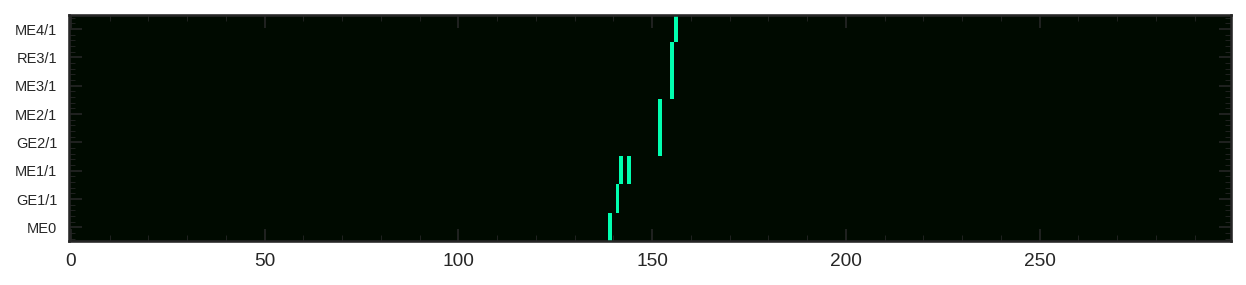

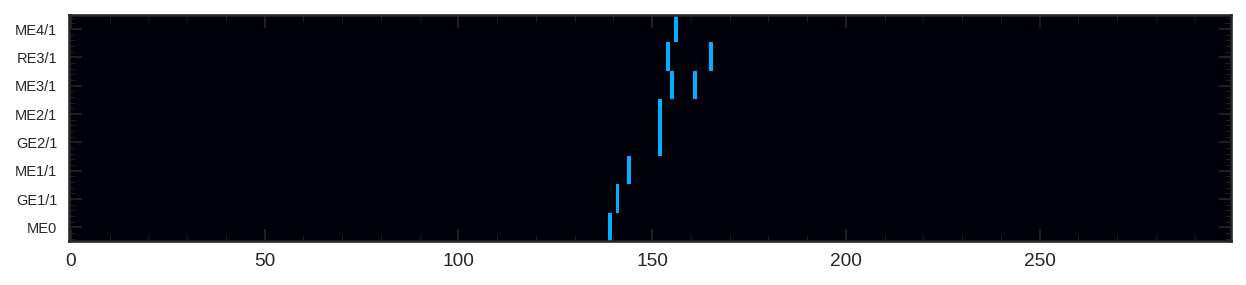

Event 1
pt: 2.4971102464370647


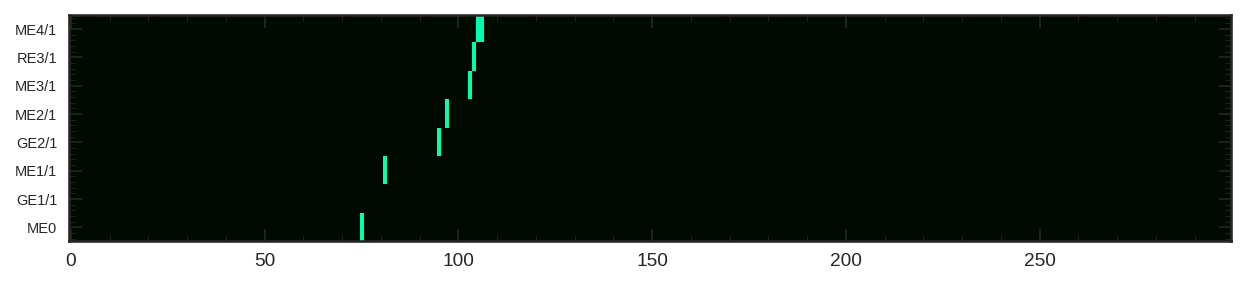

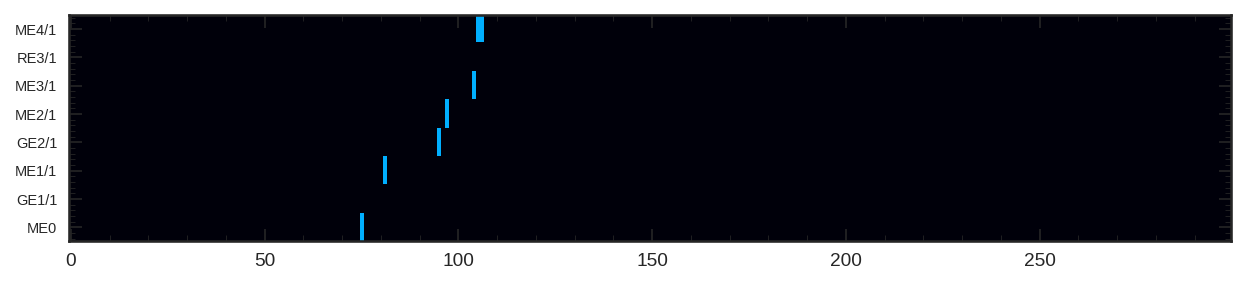

Event 2
pt: 5.663785072639632


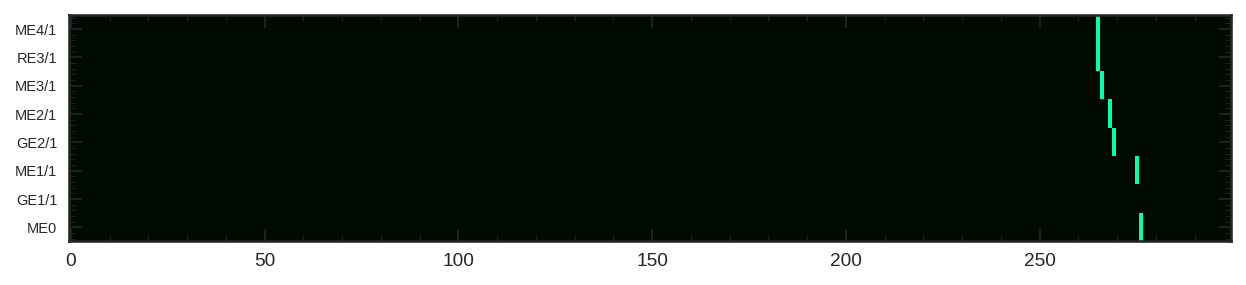

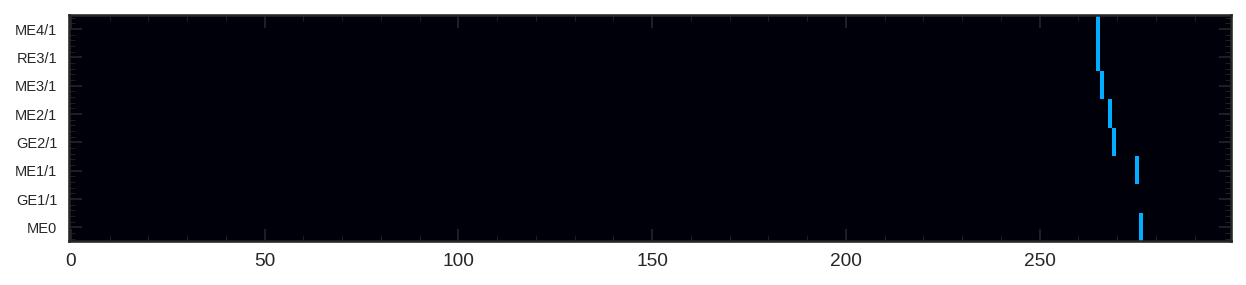

Event 3
pt: 2.8833165498640896


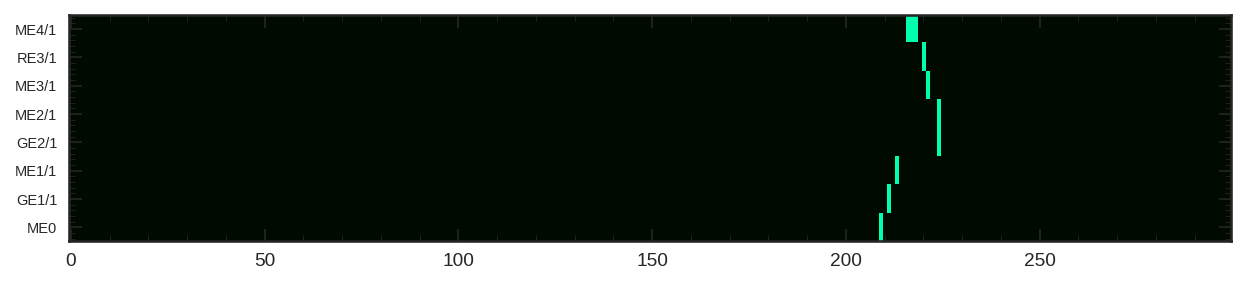

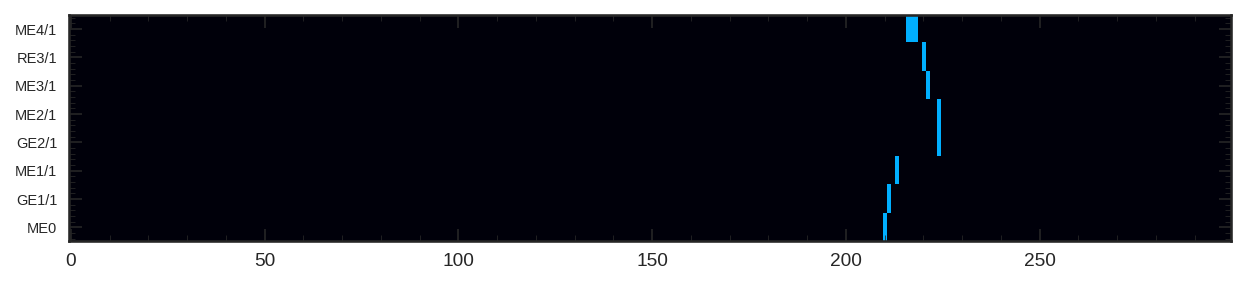

Event 4
pt: 3.2102988474779424


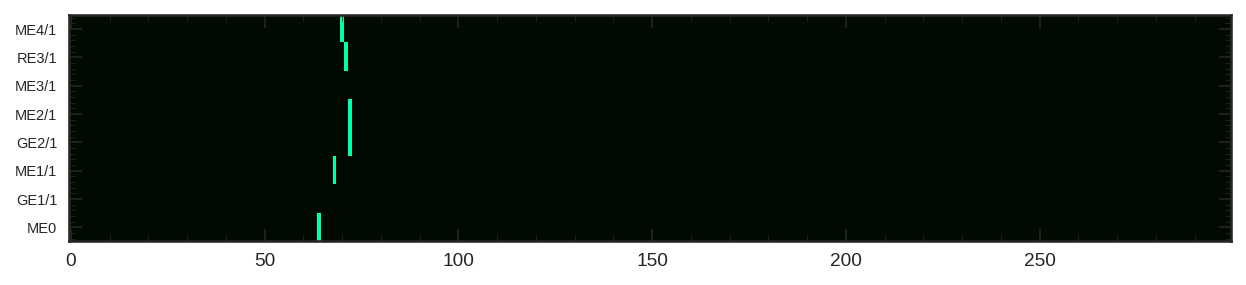

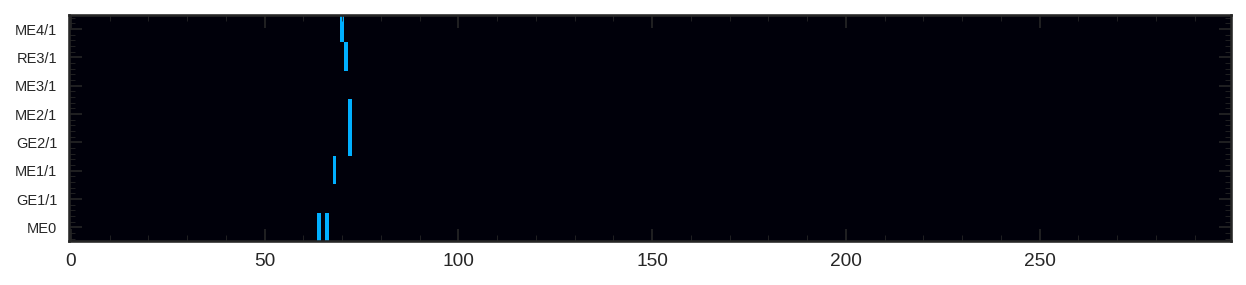

In [17]:
# Debug
for ievt in range(5):
  print('Event {0}'.format(ievt))
  print('pt: {0}'.format(1.0/np.abs(zone_part[ievt, 0])))
  display_image(zone_images_gt[ievt], cmap=green_hot)
  display_image(zone_images[ievt])

### Crop images

In [18]:
# Build boxes

box_invpt_bins, box_d0_bins = digitize_invpt_and_d0(zone_part[:, ind_part_invpt],
                                                    zone_part[:, ind_part_d0])

@njit
def get_box_ranges(anchor_col):
  start = max(0, anchor_col - box_col_offset)
  stop = min(num_cols, anchor_col + box_col_offset + 1)
  b_start = max(0, num_box_cols - stop)
  b_stop = min(num_box_cols, num_cols - start)
  #assert len(range(start, stop)) == len(range(b_start, b_stop))
  return (start, stop, b_start, b_stop)

def build_boxes():
  # 5 indices: (d0_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_d0_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  build_boxes_jit_0(zone_images_gt,
                    box_invpt_bins,
                    box_d0_bins,
                    boxes)
  return boxes

@njit
def build_boxes_jit_0(zone_images_gt,
                      box_invpt_bins,
                      box_d0_bins,
                      boxes):
  # Loop over images. Check if any hit exists in anchor_row.
  for i in range(zone_images_gt.shape[0]):
    img = zone_images_gt[i]
    box_d0_bin, box_invpt_bin = box_d0_bins[i], box_invpt_bins[i]
    if np.any(img[anchor_row, :, 0]):  # only images with true anchors
      # Canon image
      box = boxes[box_d0_bin, box_invpt_bin]
      anchor_col = np.argmax(img[anchor_row, :, 0])
      build_boxes_jit_1(img, box, anchor_col)
      # Mirror image
      img = img[:, ::-1, :]
      box = boxes[(num_d0_bins-1) - box_d0_bin, (num_invpt_bins-1) - box_invpt_bin]
      anchor_col = np.argmax(img[anchor_row, :, 0])
      build_boxes_jit_1(img, box, anchor_col)

@njit
def build_boxes_jit_1(img, box, anchor_col):
  # Normalize image.
  norm = img.sum(axis=-1).sum(axis=-1)
  norm[norm == 0] = 1
  #img = img.astype(np.float32) / norm[:, np.newaxis, np.newaxis]  # unsupported by numba

  # Accumulate.
  start, stop, b_start, b_stop = get_box_ranges(anchor_col)
  tmp_img = img[:, start:stop, :]
  #box[:, b_start:b_stop, :] += tmp_img  # slow for numba
  for i in range(tmp_img.shape[0]):
    for j in range(tmp_img.shape[1]):
      for k in range(tmp_img.shape[2]):
        if (tmp_img[i, j, k] > 0):
          box[i, b_start+j, k] += (1.0/norm[i]) * tmp_img[i, j, k]

def postprocess_boxes(boxes, antialias=True, suppress=True):
  tmp_boxes = boxes.copy()
  if antialias:
    # Applied to anchor_row (ME2) and anchor_row-1 (RE2 or GE2)
    kernel = np.array([1., 2., 1.], dtype=boxes.dtype)
    kernel /= kernel.sum()
    for i in range(tmp_boxes.shape[0]):
      for j in range(tmp_boxes.shape[1]):
        for k in [anchor_row, anchor_row-1]:
          img = boxes[i, j, k, :, 0]
          for l in range(1, img.shape[0]-1):
            tmp_boxes[i, j, k, l, 0] = (img[l-1:l+2] * kernel).sum()

  # Normalize image
  norm = np.sqrt(np.square(tmp_boxes).sum(axis=-1).sum(axis=-1))
  norm[norm == 0] = 1
  boxes_norm = tmp_boxes / norm[:, :, :, np.newaxis, np.newaxis]

  if suppress:
    # Find longest run with valid elements
    def find_longest_run(valid):
      changed = np.append(False, valid[:-1] != valid[1:])
      starts = np.arange(len(valid), dtype=np.int32)
      stops = starts.copy()
      c = 0
      for i in range(len(valid)):
        if valid[i]:
          if changed[i]:
            c = i
          stops[c] += 1
      lengths = (stops - starts)
      c = np.argmax(lengths)
      return (starts[c], stops[c])

    # Suppress small values
    for i in range(tmp_boxes.shape[0]):
      for j in range(tmp_boxes.shape[1]):
        for k in range(tmp_boxes.shape[2]):
          img = boxes[i, j, k, :, 0]
          start, stop = find_longest_run(img > 1./num_box_cols)
          # Set values outside the longest run to zero
          img[:start] = 0
          img[stop:] = 0
  return (boxes_norm, boxes)


In [19]:
# Display boxes

def display_boxes(boxes, cmap=None, figsize=(7.5,7.5)):
  fig, axs = plt.subplots(num_d0_bins, num_invpt_bins, figsize=figsize,
                          sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))
  for i in range(num_d0_bins):
    for j in range(num_invpt_bins):
      ax = axs[(num_d0_bins-1)-i, j]  # axs[0,0] is top left
      img = boxes[i, j]
      ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.grid(False)
      for x in [-40, -20, 0, +20, +40]:  # custom grid lines
        ax.plot([box_col_offset+x,box_col_offset+x], [-0.5,num_box_rows-0.5], color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

def display_box(img, cmap=None, figsize=(3,3)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.grid(False)
  for x in [-40, -20, 0, +20, +40]:  # custom grid lines
    ax.plot([box_col_offset+x,box_col_offset+x], [-0.5,num_box_rows-0.5], color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

In [20]:
%%time

boxes = build_boxes()
boxes_norm, boxes = postprocess_boxes(boxes)

logger.info('boxes_norm: {0} boxes: {1}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 28.3 s, sys: 361 ms, total: 28.7 s
Wall time: 28.6 s


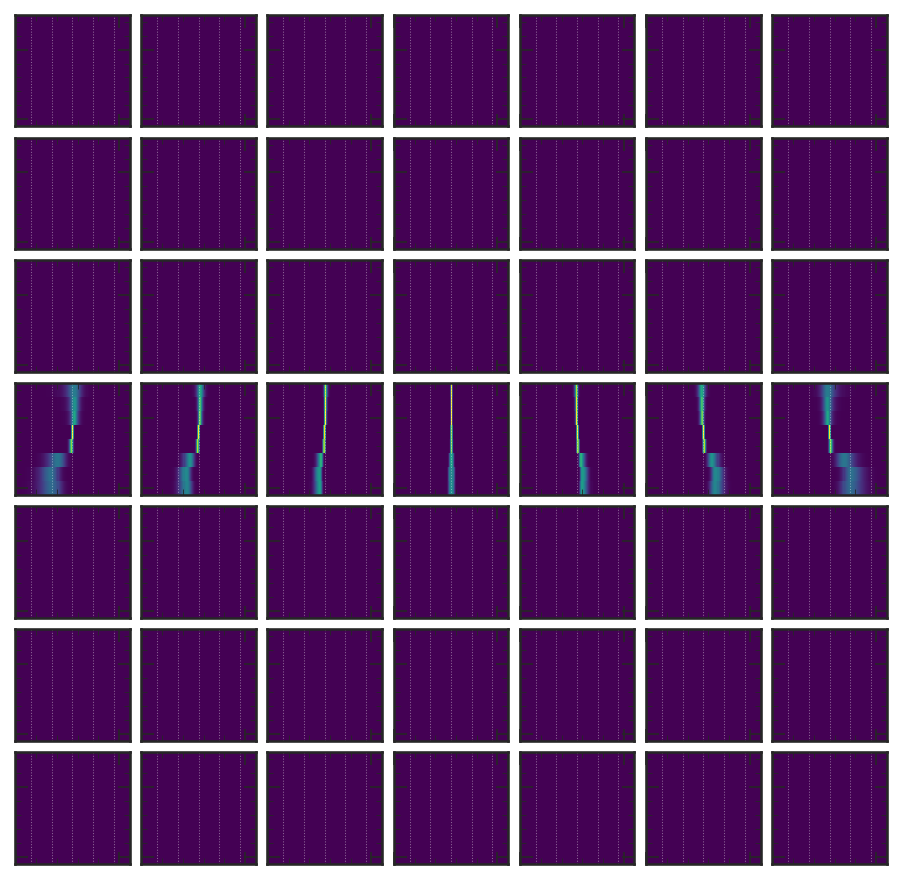

In [21]:
display_boxes(boxes_norm)

In [22]:
# Crop images

def build_zone_box_images():
  # zone_box_images_gt are made from sim hits, while zone_box_images are made from trigger primitives.
  # 'gt' stands for ground truth.
  zone_box_images_gt = np.zeros((zone_part.shape[0],) + box_image_format, dtype=np.bool)
  zone_box_images = np.zeros((zone_part.shape[0],) + box_image_format, dtype=np.bool)
  zone_box_anchors = np.zeros(zone_part.shape[0], dtype=np.int32)

  # Find anchors.
  build_zone_box_images_jit_0(zone_images_gt,
                              box_invpt_bins,
                              box_d0_bins,
                              boxes_norm,
                              zone_box_anchors)

  # Build zone_box_images_gt.
  build_zone_box_images_jit_2(zone_images_gt,
                              zone_box_anchors,
                              zone_box_images_gt)
  # Build zone_box_images.
  build_zone_box_images_jit_2(zone_images,
                              zone_box_anchors,
                              zone_box_images)
  return (zone_box_images_gt, zone_box_images, zone_box_anchors)

@njit
def build_zone_box_images_jit_0(zone_images_gt,
                                box_invpt_bins,
                                box_d0_bins,
                                boxes_norm,
                                zone_box_anchors):
  # Loop over images. Find the anchor_col.
  for i in range(zone_images_gt.shape[0]):
    img = zone_images_gt[i]
    box = boxes_norm[box_d0_bins[i], box_invpt_bins[i]]
    zone_box_anchors[i] = build_zone_box_images_jit_1(img, box)

@njit
def build_zone_box_images_jit_1(img, box):
  accumulated = np.zeros(num_cols, dtype=np.float32)

  # Guess the possible anchor_col values
  img_cols = []
  for i in range(num_cols):
    if img[:, i, :].any():
      img_cols.append(i)
  img_cols_start = max(0, img_cols[0]-10)
  img_cols_stop = min(num_cols, img_cols[-1]+11)

  # Loop over the possible anchor_col values.
  for anchor_col in range(img_cols_start, img_cols_stop):
    # Accumulate.
    start, stop, b_start, b_stop = get_box_ranges(anchor_col)
    tmp_img = img[:, start:stop, :]
    #accumulated[anchor_col] += np.sum(box[:, b_start:b_stop, :] * tmp_img)  # slow for numba
    for i in range(tmp_img.shape[0]):
      for j in range(tmp_img.shape[1]):
        for k in range(tmp_img.shape[2]):
          if (box[i, b_start+j, k] > 0) or (tmp_img[i, j, k] > 0):
            accumulated[anchor_col] += box[i, b_start+j, k] * tmp_img[i, j, k]

  # Get the best anchor_col
  anchor_col = np.argmax(accumulated)
  return anchor_col

@njit
def build_zone_box_images_jit_2(zone_images_gt,
                                zone_box_anchors,
                                zone_box_images_gt):
  # Loop over images. Crop around anchor_col.
  for i in range(zone_images_gt.shape[0]):
    anchor_col = zone_box_anchors[i]
    start, stop, b_start, b_stop = get_box_ranges(anchor_col)
    zone_box_images_gt[i][:, b_start:b_stop, :] = zone_images_gt[i][:, start:stop, :]


In [23]:
%%time

zone_box_images_gt, zone_box_images, zone_box_anchors = build_zone_box_images()

logger.info('zone_box_images_gt: {0} zone_box_images: {1} zone_box_anchors: {2}'.format(zone_box_images_gt.shape, zone_box_images.shape, zone_box_anchors.shape))

[INFO    ] zone_box_images_gt: (762362, 8, 111, 1) zone_box_images: (762362, 8, 111, 1) zone_box_anchors: (762362,)


CPU times: user 1min 27s, sys: 1.59 s, total: 1min 29s
Wall time: 1min 29s


Event 0
pt: 3.904554343228413


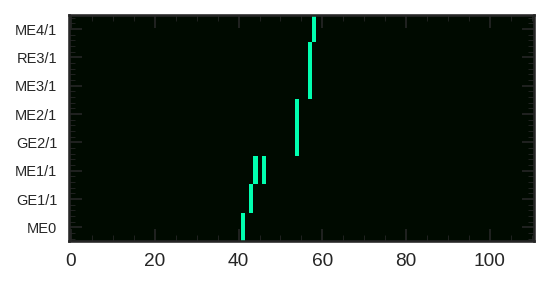

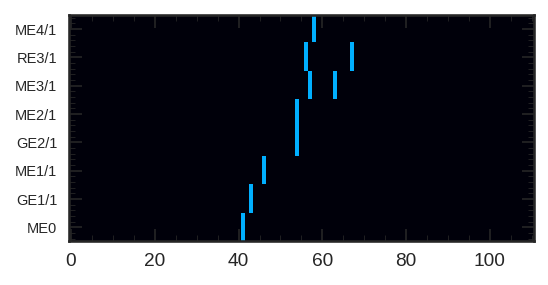

Event 1
pt: 2.4971102464370647


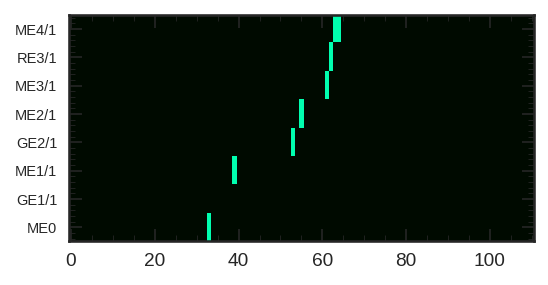

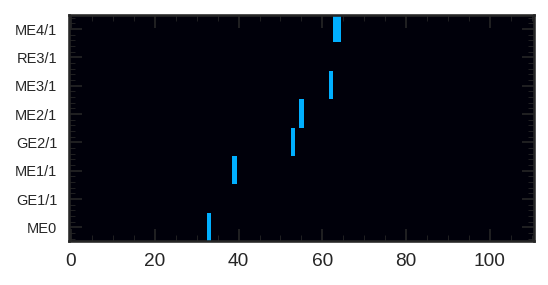

Event 2
pt: 5.663785072639632


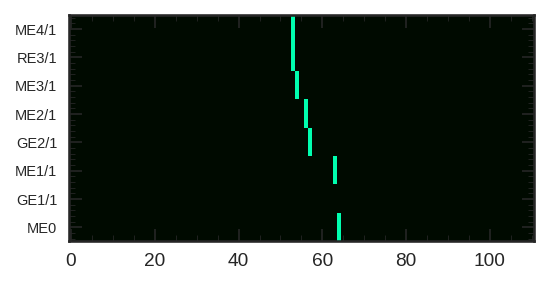

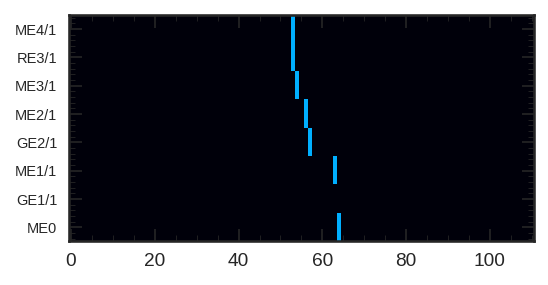

Event 3
pt: 2.8833165498640896


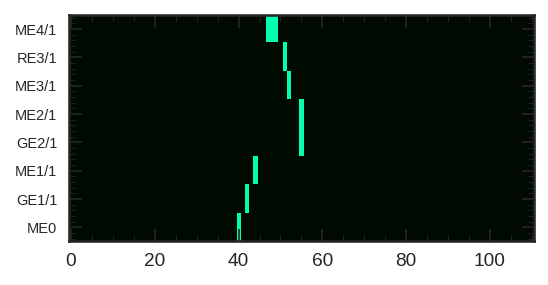

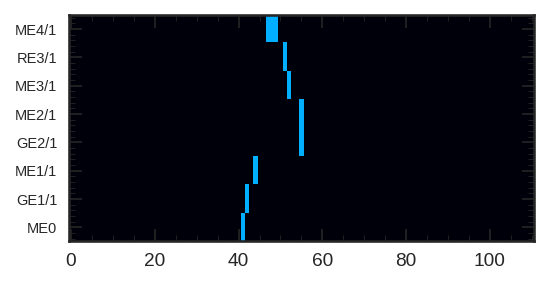

Event 4
pt: 3.2102988474779424


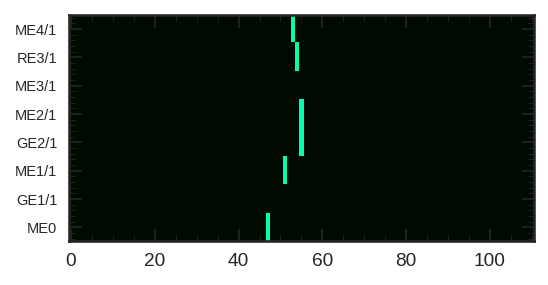

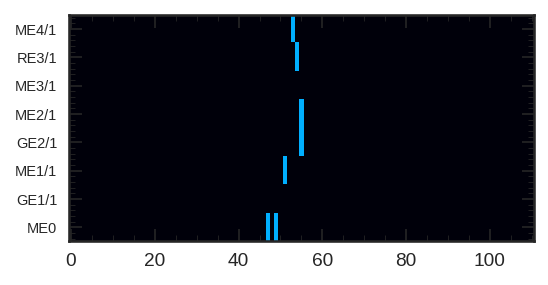

In [24]:
# Debug
for ievt in range(5):
  print('Event {0}'.format(ievt))
  print('pt: {0}'.format(1.0/np.abs(zone_part[ievt, 0])))
  display_image(zone_box_images_gt[ievt], figsize=(4,2), cmap=green_hot)
  display_image(zone_box_images[ievt], figsize=(4,2))

In [25]:
# Rebuild boxes from cropped images

def rebuild_boxes():
  # 5 indices: (d0_bin, invpt_bin, img_row, img_col, img_channel)
  boxes = np.zeros((num_d0_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

  # Build from zone_box_images (instead of zone_box_images_gt)
  rebuild_boxes_jit_0(zone_box_images,
                      box_invpt_bins,
                      box_d0_bins,
                      boxes)
  return boxes

@njit
def rebuild_boxes_jit_0(zone_box_images,
                        box_invpt_bins,
                        box_d0_bins,
                        boxes):
  # Loop over images. Check if any hit exists in anchor_row.
  for i in range(zone_box_images.shape[0]):
    img = zone_box_images[i]
    box_d0_bin, box_invpt_bin = box_d0_bins[i], box_invpt_bins[i]
    if True:  # all images (with or without anchors)
      # Canon image
      box = boxes[box_d0_bin, box_invpt_bin]
      anchor_col = box_col_offset
      build_boxes_jit_1(img, box, anchor_col)
      # Mirror image
      img = img[:, ::-1, :]
      box = boxes[(num_d0_bins-1) - box_d0_bin, (num_invpt_bins-1) - box_invpt_bin]
      anchor_col = box_col_offset
      build_boxes_jit_1(img, box, anchor_col)

In [26]:
%%time

boxes = rebuild_boxes()
boxes_norm, boxes = postprocess_boxes(boxes, antialias=False, suppress=False)

logger.info('boxes_norm: {0} boxes: {1}'.format(boxes_norm.shape, boxes.shape))

[INFO    ] boxes_norm: (7, 7, 8, 111, 1) boxes: (7, 7, 8, 111, 1)


CPU times: user 15.2 s, sys: 57.3 ms, total: 15.2 s
Wall time: 15.2 s


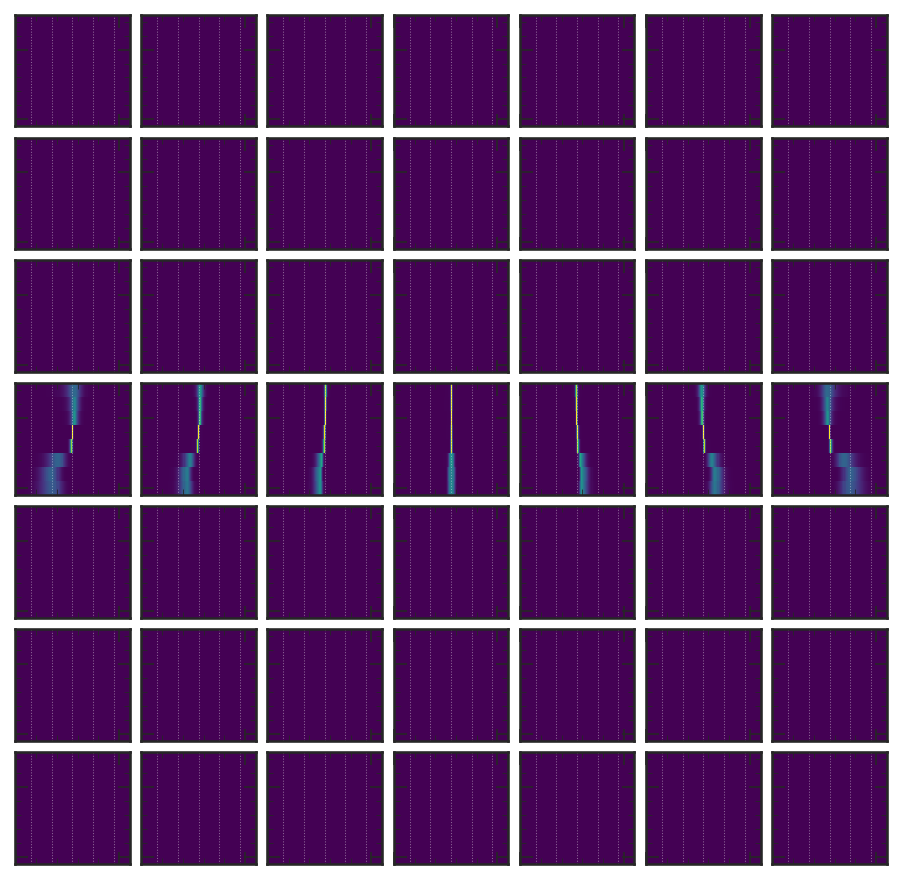

In [27]:
display_boxes(boxes_norm)

### Create patterns

In [28]:
# Apply activation threshold

boxes_act = (boxes_norm > activation)

# Check for weird spikes
def antispike():
  tmp_boxes = boxes_act.copy()
  for i in range(tmp_boxes.shape[0]):
    for j in range(tmp_boxes.shape[1]):
      for k in range(tmp_boxes.shape[2]):
        img = tmp_boxes[i, j, k, :, 0]
        for l in range(1, img.shape[0]-1):
          if img[l] and not img[l-1] and not img[l+1]:
            print('Found spike at {0}'.format((i, j, k, l, 0)))

antispike()

In [29]:
# Ad-hoc fixes

if zone == 0:
  pass
elif zone == 1:
  boxes_act[3, 0, 0, 42, 0] = 0
  boxes_act[3, 0, 1, 45, 0] = 0
  boxes_act[3, 0, 3, 58, 0] = 0
  boxes_act[3, 6, 0, 68, 0] = 0
  boxes_act[3, 6, 1, 65, 0] = 0
  boxes_act[3, 6, 3, 52, 0] = 0
elif zone == 2:
  boxes_act[3, 3, 4, 54, 0] = 1
  boxes_act[3, 3, 4, 56, 0] = 1
  #
  boxes_act[3, 0, 2, 58, 0] = 0
  boxes_act[3, 0, 2, 59, 0] = 0
  boxes_act[3, 6, 2, 52, 0] = 0
  boxes_act[3, 6, 2, 51, 0] = 0

antispike()

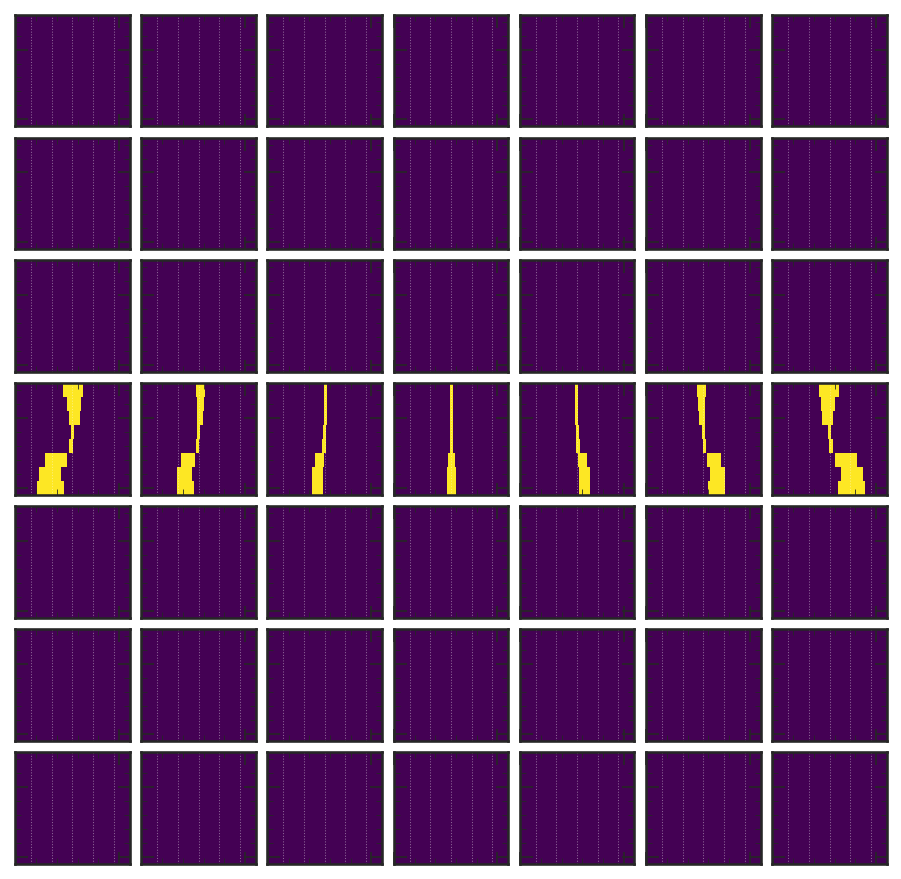

In [30]:
display_boxes(0.8 * boxes_act)

In [31]:
check_efficiency_activation = False

if check_efficiency_activation:
  def find_efficiency_activation(boxes_act_tmp):
    # Count number of stations before and after applying patterns
    accumulated = np.zeros((num_d0_bins, num_invpt_bins), dtype=np.int32)
    accumulated_act = np.zeros((num_d0_bins, num_invpt_bins), dtype=np.int32)

    for i in range(num_d0_bins):
      for j in range(num_invpt_bins):
        mask = (box_d0_bins == i) & (box_invpt_bins == j)
        tmp_images = zone_box_images[mask]
        box = boxes_act_tmp[i, j]
        accumulated[i, j] += (tmp_images.any(axis=-1).any(axis=-1)).sum(axis=-1).sum(axis=-1)
        accumulated_act[i, j] += ((box & tmp_images).any(axis=-1).any(axis=-1)).sum(axis=-1).sum(axis=-1)

    accumulated[accumulated == 0] = 1
    result = np.true_divide(accumulated_act, accumulated)
    return result.astype(np.float32)

  with np.printoptions(precision=5):
    for act in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]:
      boxes_act_tmp = (boxes_norm > act)
      print(act, find_efficiency_activation(boxes_act_tmp))

In [32]:
check_pattern_overlaps = False

if check_pattern_overlaps:
  display_box(0.5 * boxes_act[3,3], figsize=(2,2))
  display_box(0.5 * boxes_act[3,3] + 0.5 * boxes_act[3,4], figsize=(2,2))
  display_box(0.5 * boxes_act[3,4] + 0.5 * boxes_act[3,5], figsize=(2,2))
  display_box(0.5 * boxes_act[3,5] + 0.5 * boxes_act[3,6], figsize=(2,2))

In [33]:
# Debug
for j in range(num_invpt_bins):
  print(1.0 * boxes_act[3, j, anchor_row, box_col_offset-10:box_col_offset+11].reshape(-1))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
# Debug
for j in range(num_invpt_bins):
  print(1.0 * boxes_act[3, j, anchor_row-1, box_col_offset-10:box_col_offset+11].reshape(-1))

[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


In [35]:
boxes_middle = boxes[..., 0].argmax(axis=-1)
#print(boxes_middle)

# Ad-hoc fixes
boxes_middle[3, 3, :] = box_col_offset

boxes_middle = np.asarray(boxes_middle, dtype=np.int32)
boxes_start = np.zeros(boxes_middle.shape, dtype=np.int32)
boxes_stop = np.zeros(boxes_middle.shape, dtype=np.int32)

for i in range(boxes_act.shape[0]):
  for j in range(boxes_act.shape[1]):
    for k in range(boxes_act.shape[2]):
      for l in range(boxes_act.shape[3]):
        if boxes_act[i, j, k, l, 0] == 1:
          boxes_start[i, j, k] = l
          break
      for l in reversed(range(boxes_act.shape[3])):
        if boxes_act[i, j, k, l, 0] == 1:
          boxes_stop[i, j, k] = l
          break

patterns = np.stack((boxes_start, boxes_middle, boxes_stop))
patterns = np.moveaxis(patterns, 0, -1)

logger.info('patterns: {0}'.format(patterns.shape))

[INFO    ] patterns: (7, 7, 8, 3)


In [36]:
# Debug
print(patterns[3, :])

boxes_act2 = np.zeros(boxes_act.shape, dtype=boxes_act.dtype)
for i in range(patterns.shape[0]):
  for j in range(patterns.shape[1]):
    for k in range(patterns.shape[2]):
      l0, l1, l2 = patterns[i, j, k]
      if l2 > l0:
        boxes_act2[i, j, k, l0:l2+1, 0] = 1
assert np.all(boxes_act2 == boxes_act)

[[[21 36 46]
  [23 35 43]
  [29 41 49]
  [52 54 55]
  [54 55 56]
  [52 57 62]
  [50 57 63]
  [46 57 65]]

 [[35 44 50]
  [35 44 48]
  [39 47 51]
  [53 54 55]
  [54 55 56]
  [54 56 59]
  [54 57 60]
  [53 57 61]]

 [[43 51 53]
  [43 51 53]
  [46 52 54]
  [53 55 56]
  [54 55 56]
  [55 56 57]
  [55 56 57]
  [55 56 57]]

 [[51 55 59]
  [51 55 59]
  [52 55 58]
  [54 55 56]
  [54 55 56]
  [54 55 56]
  [54 55 56]
  [54 55 56]]

 [[57 59 67]
  [57 59 67]
  [56 58 64]
  [54 55 57]
  [54 55 56]
  [53 54 55]
  [53 54 55]
  [53 54 55]]

 [[60 66 75]
  [62 66 75]
  [59 63 71]
  [55 56 57]
  [54 55 56]
  [51 54 56]
  [50 53 56]
  [49 53 57]]

 [[64 74 89]
  [67 75 87]
  [61 69 81]
  [55 56 58]
  [54 55 56]
  [48 53 58]
  [47 53 60]
  [45 53 64]]]


In [37]:
# Write to file
outfile = 'patterns_zone%i.npz' % zone
outdict = {
  'patterns': patterns,
  'boxes_act': boxes_act,
  'boxes_norm': boxes_norm,
  'boxes': boxes,
}
save_np_arrays(outfile, outdict)
logger.info('Wrote to {0}'.format(outfile))

[INFO    ] Wrote to patterns_zone0.npz


In [38]:
zone_sparse_images_gt = dense_to_sparse(zone_images_gt)
zone_sparse_images = dense_to_sparse(zone_images)
logger.info('zone_sparse_images_gt: {0} zone_sparse_images: {1}'.format(zone_sparse_images_gt.dense_shape, zone_sparse_images.dense_shape))

[INFO    ] zone_sparse_images_gt: (762362, 8, 300, 1) zone_sparse_images: (762362, 8, 300, 1)


In [39]:
# Write to hdf5 file
outfile = 'zone_images_zone%i.h5' % zone
outdict = {
  'zone_part': da.from_array(zone_part),
  'zone_hits_values': da.from_array(zone_hits.values),
  'zone_hits_row_splits': da.from_array(zone_hits.row_splits),
  'zone_simhits_values': da.from_array(zone_simhits.values),
  'zone_simhits_row_splits': da.from_array(zone_simhits.row_splits),
  'zone_box_anchors': da.from_array(zone_box_anchors),
  'zone_sparse_images_gt_indices': da.from_array(zone_sparse_images_gt.indices),
  'zone_sparse_images_gt_values': da.from_array(zone_sparse_images_gt.values),
  'zone_sparse_images_gt_dense_shape': da.from_array(zone_sparse_images_gt.dense_shape),
  'zone_sparse_images_indices': da.from_array(zone_sparse_images.indices),
  'zone_sparse_images_values': da.from_array(zone_sparse_images.values),
  'zone_sparse_images_dense_shape': da.from_array(zone_sparse_images.dense_shape),
}
da.to_hdf5(outfile, outdict)
logger.info('Wrote to {0}'.format(outfile))

[INFO    ] Wrote to zone_images_zone0.h5


### Tune invpt and d0 binning (disabled)

In [40]:
check_binning_invpt_and_d0 = False

if check_binning_invpt_and_d0:
  zone_part_invpt_tmp = zone_part[:, ind_part_invpt]
  zone_part_invpt_tmp = np.hstack((zone_part_invpt_tmp, -zone_part_invpt_tmp))
  zone_part_dzero_tmp = zone_part[:, ind_part_d0]
  zone_part_dzero_tmp = np.hstack((zone_part_dzero_tmp, -zone_part_dzero_tmp))
  with np.printoptions(precision=5):
    #print('invpt_bins:\n', np.percentile(zone_part_invpt_tmp, [0.5,100./7,200./7,300./7,400./7,500./7,600./7,99.5], overwrite_input=True))
    #print('dzero_bins:\n', np.percentile(zone_part_dzero_tmp, [0.5,300./12,500./12,588./12,612./12,700./12,900./12,99.5], overwrite_input=True))
    if zone == 0:
      print('invpt_bins:\n', np.percentile(zone_part_invpt_tmp, [0.5, 18.75, 31.25, 43.75, 56.25, 68.75, 81.25, 99.5], overwrite_input=True))
    elif zone == 1:
      print('invpt_bins:\n', np.percentile(zone_part_invpt_tmp, [0.5, 17.5, 30.0, 44.0, 56.0, 70.0, 82.5, 99.5], overwrite_input=True))
    elif zone == 2:
      print('invpt_bins:\n', np.percentile(zone_part_invpt_tmp, [0.5, 18.75, 31.25, 42.5, 57.5, 68.75, 81.25, 99.5], overwrite_input=True))

In [41]:
really_check_binning_invpt_and_d0 = False

if really_check_binning_invpt_and_d0:
  invpt_bins_tmp = np.array([-1000., -1000., -1000., -1000., 1000., 1000., 1000., 1000.])
  dzero_bins_tmp = np.array([-1000., -1000., -1000., -1000., 1000., 1000., 1000., 1000.])
  invpt_bins_pct_tmp = np.array([-1000., -1000, -1000., -1000., 1000., 1000., 1000., 1000.])
  dzero_bins_pct_tmp = np.array([-1000., -1000, -1000., -1000., 1000., 1000., 1000., 1000.])

  def digitize_invpt_and_d0_tmp(invpt, d0):
    # returns (d0_bin, invpt_bin)
    ind0 = my_digitize(invpt, invpt_bins_tmp)  # use invpt_bins_tmp
    ind1 = my_digitize(d0, dzero_bins_tmp)     # use dzero_bins_tmp
    return (ind0, ind1)

  def rebuild_boxes_tmp():
    # 5 indices: (d0_bin, invpt_bin, img_row, img_col, img_channel)
    boxes = np.zeros((num_d0_bins, num_invpt_bins) + box_image_format, dtype=np.float32)

    # Call digitize_invpt_and_d0_tmp()
    box_invpt_bins, box_d0_bins = digitize_invpt_and_d0_tmp(zone_part[:, ind_part_invpt],
                                                            zone_part[:, ind_part_d0])

    # Build from zone_box_images (instead of zone_box_images_gt)
    rebuild_boxes_jit_0(zone_box_images,
                        box_invpt_bins,
                        box_d0_bins,
                        boxes)
    return boxes

  def find_efficiency_activation_tmp(boxes_act_tmp):
    # Count number of stations before and after applying patterns
    accumulated = np.zeros((num_d0_bins, num_invpt_bins), dtype=np.int32)
    accumulated_act = np.zeros((num_d0_bins, num_invpt_bins), dtype=np.int32)

    # Call digitize_invpt_and_d0_tmp()
    box_invpt_bins, box_d0_bins = digitize_invpt_and_d0_tmp(zone_part[:, ind_part_invpt],
                                                            zone_part[:, ind_part_d0])

    for i in range(num_d0_bins):
      for j in range(num_invpt_bins):
        mask = (box_d0_bins == i) & (box_invpt_bins == j)
        tmp_images = zone_box_images[mask]
        box = boxes_act_tmp[i, j]
        accumulated[i, j] += (tmp_images.any(axis=-1).any(axis=-1)).sum(axis=-1).sum(axis=-1)
        accumulated_act[i, j] += ((box & tmp_images).any(axis=-1).any(axis=-1)).sum(axis=-1).sum(axis=-1)

    accumulated[accumulated == 0] = 1
    result = np.true_divide(accumulated_act, accumulated)
    return result.astype(np.float32)

  me1_row = find_emtf_zo_layer(0, zone)    # ME1/1
  if me1_row == -99:
    me1_row = find_emtf_zo_layer(1, zone)  # ME1/2

  zone_part_invpt_tmp = zone_part[:, ind_part_invpt]
  zone_part_invpt_tmp = np.hstack((zone_part_invpt_tmp, -zone_part_invpt_tmp))
  zone_part_dzero_tmp = zone_part[:, ind_part_d0]
  zone_part_dzero_tmp = np.hstack((zone_part_dzero_tmp, -zone_part_dzero_tmp))

  # 40 edges in invpt
  N = 40
  _linspace = np.linspace(0, 100, num=2*N+1)
  _linspace[0] += 0.5
  _linspace[-1] -= 0.5
  zone_part_invpt_pct = np.percentile(zone_part_invpt_tmp, _linspace, overwrite_input=True)
  #print(_linspace, zone_part_invpt_pct, sep='\n')

  def find_efficiency_and_area():
    boxes_tmp = rebuild_boxes_tmp()
    boxes_norm_tmp, boxes_tmp = postprocess_boxes(boxes_tmp, antialias=False, suppress=False)
    #display_boxes(boxes_norm_tmp)
    boxes_act_tmp = (boxes_norm_tmp > activation)
    eff = find_efficiency_activation_tmp(boxes_act_tmp)
    eff = eff[R, S]
    area = np.flatnonzero(boxes_act_tmp[R, S, me1_row, :, 0])
    return (eff, area)

  # Result array
  result = np.zeros((num_d0_bins, num_invpt_bins) + (N,), dtype=np.float32)

  R, S = 3, 3  # (d0_bin, invpt_bin)
  S1, S2 = S, S+1  # edges for invpt_bin
  for i in range(N):
    invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(i+1)]
    invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(i+1)]
    with np.printoptions(precision=5):
      print(i, invpt_bins_tmp)

    eff, area = find_efficiency_and_area()
    result[R, S, i] = eff / len(area)
    with np.printoptions(precision=5):
      print(result[R, S, i], eff, area)

    if result[R, S, i] < 0.05:
      break

  # Plot
  print(result[R, S])
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.plot(range(len(result[R, S])), result[R, S])
  ax.set_ylim(0,0.5)

In [42]:
if really_check_binning_invpt_and_d0:
  best_i = 4  # insert by hand
  invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(best_i+1)]
  invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(best_i+1)]
  invpt_bins_pct_tmp[S1] = _linspace[N-(best_i+1)]
  invpt_bins_pct_tmp[S2] = _linspace[N+(best_i+1)]

  R, S = 3, 4  # (d0_bin, invpt_bin)
  S1, S2 = S-2, S+1  # edges for invpt_bin
  for i in range(best_i+1, N):
    invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(i+1)]
    invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(i+1)]
    with np.printoptions(precision=5):
      print(i, invpt_bins_tmp)

    eff, area = find_efficiency_and_area()
    result[R, S, i] = eff / len(area)
    with np.printoptions(precision=5):
      print(result[R, S, i], eff, area)

    if result[R, S, i] < 0.05:
      break

  # Plot
  print(result[R, S])
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.plot(range(len(result[R, S])), result[R, S])
  ax.set_ylim(0,0.5)

In [43]:
if really_check_binning_invpt_and_d0:
  best_i = 14  # insert by hand
  invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(best_i+1)]
  invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(best_i+1)]
  invpt_bins_pct_tmp[S1] = _linspace[N-(best_i+1)]
  invpt_bins_pct_tmp[S2] = _linspace[N+(best_i+1)]

  R, S = 3, 5  # (d0_bin, invpt_bin)
  S1, S2 = S-4, S+1  # edges for invpt_bin
  for i in range(best_i+1, N):
    invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(i+1)]
    invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(i+1)]
    with np.printoptions(precision=5):
      print(i, invpt_bins_tmp)

    eff, area = find_efficiency_and_area()
    result[R, S, i] = eff / len(area)
    with np.printoptions(precision=5):
      print(result[R, S, i], eff, area)

    if result[R, S, i] < 0.04:
      break

  # Plot
  print(result[R, S])
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.plot(range(len(result[R, S])), result[R, S])
  ax.set_ylim(0,0.5)

In [44]:
if really_check_binning_invpt_and_d0:
  best_i = 24  # insert by hand
  invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(best_i+1)]
  invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(best_i+1)]
  invpt_bins_pct_tmp[S1] = _linspace[N-(best_i+1)]
  invpt_bins_pct_tmp[S2] = _linspace[N+(best_i+1)]

  R, S = 3, 6  # (d0_bin, invpt_bin)
  S1, S2 = S-6, S+1  # edges for invpt_bin
  for i in range(best_i+1, N):
    invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(i+1)]
    invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(i+1)]
    with np.printoptions(precision=5):
      print(i, invpt_bins_tmp)

    eff, area = find_efficiency_and_area()
    result[R, S, i] = eff / len(area)
    with np.printoptions(precision=5):
      print(result[R, S, i], eff, area)

    if result[R, S, i] < 0.02:
      break

  # Plot
  print(result[R, S])
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.plot(range(len(result[R, S])), result[R, S])
  ax.set_ylim(0,0.5)

In [45]:
if really_check_binning_invpt_and_d0:
  best_i = N-1  # insert by hand
  invpt_bins_tmp[S1] = zone_part_invpt_pct[N-(best_i+1)]
  invpt_bins_tmp[S2] = zone_part_invpt_pct[N+(best_i+1)]
  invpt_bins_pct_tmp[S1] = _linspace[N-(best_i+1)]
  invpt_bins_pct_tmp[S2] = _linspace[N+(best_i+1)]

  print(invpt_bins_tmp)
  print(invpt_bins_pct_tmp)